In [15]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [16]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.2.1, Device: cpu


In [17]:
# Escape SSLCertVerificationError
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [18]:
train_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True,
                              transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [19]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset) * 0.80)
validation_dataset_size = int(len(train_dataset) * 0.20)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

50000
40000 10000 10000


In [20]:
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
class MyCNNModel(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, data):

        data = self.conv1(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv2(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = data.view(-1, 8 * 8 * 64)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits

In [22]:
model = MyCNNModel().to(DEVICE)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [23]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [24]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [25]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [26]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

# Originally it was 100
EPOCHS = 5

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 1.704 train acc = 37.120 val loss = 1.379 val acc = 50.920
epoch: 02 train loss = 1.437 train acc = 47.935 val loss = 1.188 val acc = 58.550
epoch: 03 train loss = 1.321 train acc = 52.470 val loss = 1.122 val acc = 60.710
epoch: 04 train loss = 1.245 train acc = 54.940 val loss = 1.067 val acc = 62.400
epoch: 05 train loss = 1.199 train acc = 57.180 val loss = 1.001 val acc = 64.550
elapsed time =>  0:02:34.562682


In [31]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 63.97
loss: 1.017359611706231


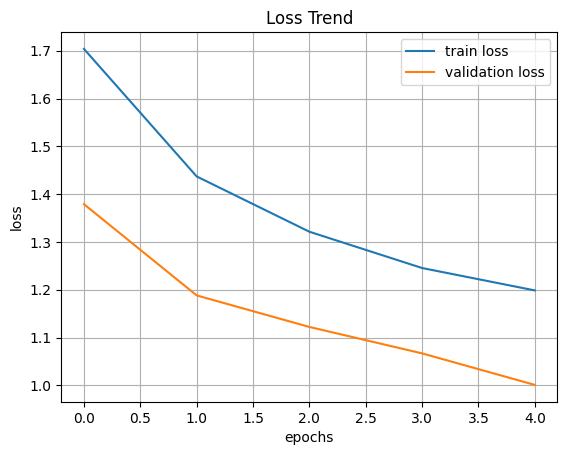

In [32]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()

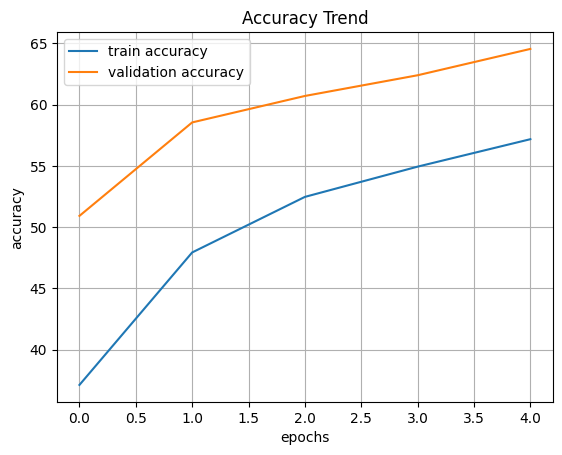

In [33]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

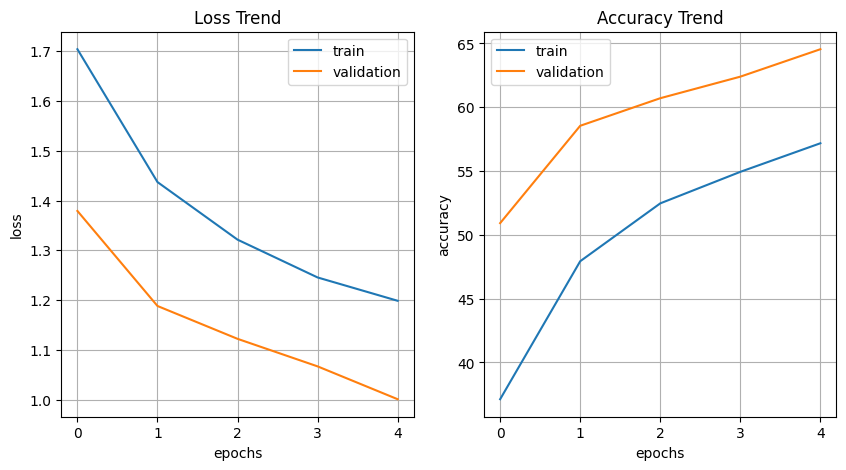

In [34]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()